In [ ]:
!pip install turicreate

In [7]:
!pip install matplotlib

DEPRECATION: Python 2.7 will reach the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 won't be maintained after that date. A future version of pip will drop support for Python 2.7. More details about Python 2 support in pip, can be found at https://pip.pypa.io/en/latest/development/release-process/#python-2-support


In [10]:
!pip install seaborn

DEPRECATION: Python 2.7 will reach the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 won't be maintained after that date. A future version of pip will drop support for Python 2.7. More details about Python 2 support in pip, can be found at https://pip.pypa.io/en/latest/development/release-process/#python-2-support
     |████████████████████████████████| 225kB 8.4MB/s eta 0:00:01


In [4]:
# import migration_detector as md
import matplotlib as mpl
%matplotlib inline

In [5]:
traj = read_csv('./example/migrant_location_history_example1.csv')

/opt/homebrew/anaconda3/envs/py27/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


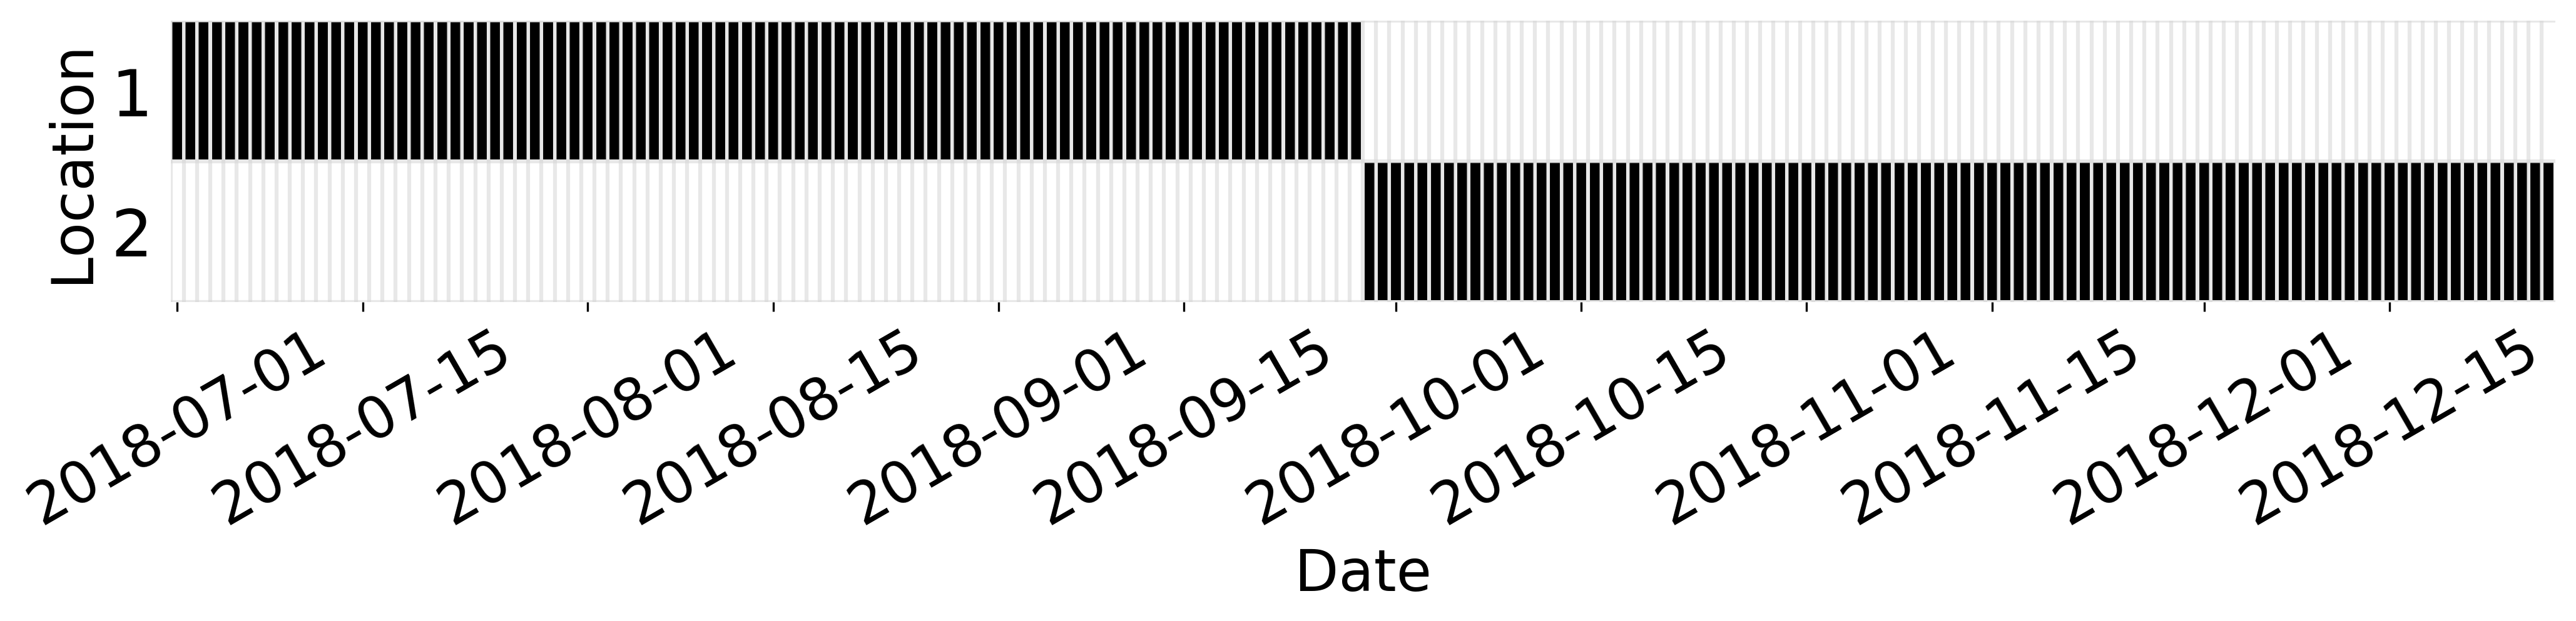

In [6]:
traj.plot_trajectory(user_id='1')

In [8]:
migrants = traj.find_migrants()
migrants

Start: Detecting migration


RuntimeError: Column name migration_day does not exist.

In [20]:
migrants = traj.find_migrants()
print(migrants['user_id', 'home', 'destination', 'migration_date',
               'uncertainty', 'num_error_day',
               'home_start', 'home_end',
               'destination_start', 'destination_end',
               'home_start_date', 'home_end_date',
               'destination_start_date', 'destination_end_date'])

Start: Detecting migration


AttributeError: ignored

In [3]:
import turicreate as gl
import pandas as pd
import numpy as np
import os
# from .core import TrajRecord


def read_csv(file_path):
    user_daily_loc_count = gl.SFrame.read_csv(file_path, verbose=False)
    user_daily_loc_count['user_id'] = user_daily_loc_count['user_id'].astype(str)
    # Prepare migration record
    # Assign day index to each date
    start_date_ori = str(user_daily_loc_count['date'].min())
    end_date_ori = str(user_daily_loc_count['date'].max())
    # MM/DD/YYYY
    start_date = '/'.join([start_date_ori[4:6], start_date_ori[6:],
                           start_date_ori[:4]])
    end_date = '/'.join([end_date_ori[4:6], end_date_ori[6:], end_date_ori[:4]])
    all_date = pd.date_range(start=start_date, end=end_date)
    all_date_new = [int(str(x)[:4] + str(x)[5:7] + str(x)[8:10])
                    for x in all_date]
    date2index = dict(zip(all_date_new, range(len(all_date_new))))
    index2date = dict(zip(range(len(all_date_new)), all_date_new))

    end_date_long_ori = str(pd.Timestamp(end_date)+pd.Timedelta('200 day'))
    all_date_long = pd.date_range(start=start_date, end=end_date_long_ori)
    all_date_long_new = [int(str(x)[:4] + str(x)[5:7] + str(x)[8:10])
                         for x in all_date_long]
    date_num_long = gl.SFrame({'date': all_date_long_new,
                               'date_num': range(len(all_date_long_new))})

    migration_df = user_daily_loc_count
    migration_df['date_num'] = migration_df.apply(
        lambda x: date2index[x['date']]
    )
    # Aggregate user daily records
    user_loc_date_agg = migration_df.groupby(
        ['user_id', 'location'],
        {'all_date': gl.aggregate.CONCAT('date_num')}
    )
    user_loc_agg = user_loc_date_agg.groupby(
        ['user_id'],
        {'all_record': gl.aggregate.CONCAT('location', 'all_date')}
    )
    traj = TrajRecord(user_loc_agg, migration_df, index2date, date_num_long)
    return traj


def to_csv(result, result_path='result', file_name='migration_event.csv'):
    if not os.path.isdir(result_path):
        os.makedirs(result_path)
    save_file = os.path.join(result_path, file_name)
    result.select_columns(
        ['user_id', 'home', 'destination', 'migration_date',
         'uncertainty', 'num_error_day',
         'home_start', 'home_end',
         'destination_start', 'destination_end',
         'home_start_date', 'home_end_date',
         'destination_start_date', 'destination_end_date']
    ).export_csv(save_file)


In [8]:
import matplotlib.pyplot as plt

In [2]:
import pandas as pd
import numpy as np
from array import array
import turicreate as gl
import matplotlib.pyplot as plt
import seaborn as sns


def fill_missing_day(all_loc_rec, k):
    """
    For any location (L) in any day, see the next k days.
    If in these k days, there is >= 1 day when this person appears in L,
    then fill the gaps with L.
    """
    result_dict = {}
    for loc in all_loc_rec.keys():
        loc_date = all_loc_rec[loc]
        loc_date.sort()
        new_loc_date = list(loc_date)
        if len(loc_date) > 1:
            for i, date in enumerate(loc_date[:-1]):
                close_date = loc_date[i+1]
                date_diff = close_date - date
                if 1 < date_diff <= k:
                    new_loc_date += range(date+1, close_date)
        new_loc_date.sort()
        result_dict[loc] = new_loc_date
    return result_dict


def find_segment(all_fill_rec, k):
    """
    Group consecutive days in the same location together into segments.
    A segment need to have consecutive days >= k days. (default k = 30)
    """
    result_dict = {}
    for loc in all_fill_rec.keys():
        loc_date = all_fill_rec[loc]
        if len(loc_date) >= k:
            loc_date_next = loc_date[1:]
            loc_date_next.append(0)
            diff_next = np.array(loc_date_next) - np.array(loc_date)

            # the index of date that is not consecutive
            # i.e., the next element is not the next date for today
            # but today could be the next date for the former element
            split_idx = np.where(diff_next != 1)[0]
            segment_idx = []

            if len(split_idx) == 1:
                # the last element in diff_next must <0
                # so all the date in loc_date are consective
                segment_idx.append([loc_date[0], loc_date[-1]])
            else:
                # the days before split_idx[0]
                if split_idx[0] >= k-1:
                    segment_idx.append([loc_date[0], loc_date[split_idx[0]]])

                for i, index in enumerate(split_idx[:-1]):
                    next_idx = split_idx[i+1]
                    # Find the start and end index of each period(consecutive days)
                    # For each period, the start and end index are defined by two
                    # nearby elements in split_idx(a list),
                    # and the two elements, which are also indexes in loc_date
                    # (the date list of loc L),
                    # should have a difference >=k,
                    # because we want the period have at least k day
                    # so in loc_date, a period must statisfy:
                    # [split_idx1, start_idx,...(k-2 days), end_idx(split_idx2)]
                    if next_idx - index >= k:
                        seg_start_idx = index + 1
                        seg_end_idx = next_idx
                        seg_start_date = loc_date[seg_start_idx]
                        seg_end_date = loc_date[seg_end_idx]
                        segment_idx.append([seg_start_date, seg_end_date])

            if len(segment_idx) > 0:
                result_dict[loc] = segment_idx

    return result_dict


def filter_seg_appear_prop(x, filter_column, prop):
    """
    Only keep those segments that appear >= prop*len(segment).
    Note: appeared days are original days before filling.
    Do it for the filled record.
    """
    all_record = x['all_record']
    to_filter_record = x[filter_column]

    result_dict = {}
    for location in to_filter_record.keys():
        loc_daily_record = all_record[location]
        loc_segment = to_filter_record[location]
        new_loc_record = []
        for segment in loc_segment:
            segment_len = segment[1] - segment[0] + 1
            appear_len = len([day for day in loc_daily_record
                              if day <= segment[1] and day >= segment[0]])
            if appear_len >= prop * segment_len:
                new_loc_record.append(segment)
        if len(new_loc_record) > 0:
            result_dict[location] = new_loc_record

    return result_dict


def join_segment_if_no_gap(old_segment):
    """
    In the same location, join continuous segments together,
    if there are no other segments within in gap period in other location.
    If there is only one location for this user,
    it means that he/she is not a migrant, return {}.
    """
    loc_list = old_segment.keys()
    new_segment = {}

    if len(loc_list) > 1:
        for location in loc_list:
            loc_record = old_segment[location]
            new_loc_record = []
            if len(loc_record) == 1:
                new_loc_record.append(loc_record[0])
            elif len(loc_record) > 1:
                current_segment = loc_record[0]
                other_loc_record = [value
                                    for key, value in old_segment.iteritems()
                                    if key != location]
                other_loc_record = [j for l in other_loc_record for j in l]
                other_loc_exist_days = [range(int(x[0]), int(x[1]) + 1)
                                        for x in other_loc_record]
                # merge sublist and unique(), set() will also sort the list automatically
                other_loc_exist_days = set([j for l in other_loc_exist_days
                                            for j in l])

                for i in range(1, len(loc_record)):
                    next_segment = loc_record[i]
                    # Find gap
                    gap = [current_segment[1] + 1, next_segment[0] - 1]
                    gap_days_list = range(int(gap[0]), int(gap[1]) + 1)
                    # Check if there are any other segments cover the gap
                    gap_other_loc_interset = set(gap_days_list) & other_loc_exist_days
                    if len(gap_other_loc_interset) == 0:
                        current_segment = [current_segment[0], next_segment[1]]
                    else:
                        new_loc_record.append(current_segment)
                        current_segment = next_segment
                new_loc_record.append(current_segment)
            new_segment[location] = new_loc_record

    return new_segment


def change_overlap_segment(x, filter_segment_col, k, d):
    """
    Check if there is any overlap period longer than k days between segments.
    If there are, remove the overlapped part rather than remove the whole segment.
    After removing the overlapped part, only keep the segments that are longer than d days.
    Return the changed segments that satisfy the rule.
    """
    segments = x[filter_segment_col]
    loc_list = segments.keys()
    remove_overlap_date_dict = {}
    change_result_dict = {}
    # Filter out any segment by k
    for location in loc_list:
        other_loc = list(set(loc_list) - set([location]))
        current_loc_changed_date = []
        for current_segment in segments[location]:
            other_segment_list = ([value for key, value in segments.iteritems()
                                   if key in other_loc])
            other_segment_list = [j for l in other_segment_list for j in l]
            current_segment_date = set(range(int(current_segment[0]), int(current_segment[1]) + 1))
            for other_segment in other_segment_list:
                other_segment_date = range(int(other_segment[0]), int(other_segment[1]) + 1)
                seg_intersect = set(current_segment_date) & set(other_segment_date)
                if len(seg_intersect) > k:
                    current_segment_date = current_segment_date - seg_intersect
            current_loc_changed_date += list(current_segment_date)
        if len(current_loc_changed_date) > 0:
          current_loc_changed_date.sort()
          remove_overlap_date_dict[location] = current_loc_changed_date

    change_result_dict = find_segment(remove_overlap_date_dict, d)

    return change_result_dict


def find_migration_by_segment(segments, k):
    """
    Filter out migration that the time period of home covers more than k days
    of the time period of destination.
    Return home_segment, destination_segment.
    """
    all_segments_date = [j for l in segments.values() for j in l]
    all_segments_date.sort()
    segment_loc_sort = []
    migration_result = []

    for current_segment in all_segments_date:
        # transform the current_segment into array('d',current_segment)
        # to match with the dict
        # depends on the format of data
        current_segment_transform = array('d', current_segment)
        current_segment_loc_list = [key for key, value in segments.iteritems()
                                    if current_segment_transform in value]
        segment_loc_sort.append(current_segment_loc_list)
    segment_loc_sort = np.array([j for l in segment_loc_sort for j in l])

    for index, current_segment in enumerate(all_segments_date[:-1]):
        # Find first different location segment
        current_loc = segment_loc_sort[index]
        other_loc_segment_idx = np.where(segment_loc_sort != current_loc)[0]

        next_segment_idx_list = filter(lambda x: x > index, other_loc_segment_idx)
        next_segment_idx_list.sort()
        if len(next_segment_idx_list) > 0:
            for i in range(len(next_segment_idx_list)):
                next_segment_idx = next_segment_idx_list[i]
                next_segment = all_segments_date[next_segment_idx]
                if next_segment[0] - current_segment[1] >= -k+1:
                    home_segment = current_segment
                    des_segment = next_segment
                    home_id = current_loc
                    des_id = segment_loc_sort[next_segment_idx]
                    migration_result.append([home_segment, des_segment,
                                             home_id, des_id])
                    break

    return migration_result


def create_migration_dict(x):
    """
    Transform migration information into a dictionary for plotting.
    """
    home_id = x[2]
    des_id = x[3]
    home_segment = x[0]
    des_segment = x[1]
    return {home_id: [home_segment], des_id: [des_segment]}


# Functions to infer migration day
def find_migration_day_segment(x):
    """
    Return migration day and minimum number of error days.
    """
    home = x['home']
    des = x['destination']
    home_seg = x['migration_segment'][home][0]
    des_seg = x['migration_segment'][des][0]
    home_end = home_seg[1]
    des_start = des_seg[0]

    # Find the day of minimun error day
    home_record_bwn = [d for d in x['all_record'][home]
                       if home_end <= d <= des_start]
    des_record_bwn = [d for d in x['all_record'][des]
                      if home_end <= d <= des_start]
    poss_m_day = range(int(home_end), int(des_start)+1)
    wrong_day_before = [[des_day
                         for des_day in des_record_bwn
                         if des_day < current_day]
                         for current_day in poss_m_day]
    num_wrong_day_before = [len(des_day_list)
                            for des_day_list in wrong_day_before]
    wrong_day_after = [[home_day
                        for home_day in home_record_bwn
                        if home_day > current_day]
                        for current_day in poss_m_day]
    num_wrong_day_after = [len(home_day_list)
                           for home_day_list in wrong_day_after]
    num_error_day = np.array(num_wrong_day_before) + np.array(num_wrong_day_after)
    min_error_idx = np.where(num_error_day == num_error_day.min())[0][-1]

    # If there are several days that the num_error_day is the minimun,
    # take the last one.
    migration_day = poss_m_day[min_error_idx]
    min_error_day = min(num_error_day)

    return [int(migration_day), int(min_error_day)]


# Functions for short term migration
def filter_migration_segment_len(x, hmin=0, hmax=float("inf"), dmin=0,
                                 dmax=float("inf")):
    """
    Filter migration segment by home segment length and destination length.
    x: ['migration_list']
    hmin: min_home_segment_len
    hmax: max_home_segment_len
    dmin: min_des_segment_len
    dmax: max_des_segment_len
    """
    home_segment = x[0]
    des_segment = x[1]
    home_len = home_segment[1]-home_segment[0]+1
    des_len = des_segment[1]-des_segment[0]+1
    if (hmin <= home_len <= hmax) and (dmin <= des_len <= dmax):
        return 1
    else:
        return 0


def plot_traj_common(traj, user_id, start_day, end_day, date_num_long):
    """
    Common code for plotting trajectory.
    (1) any individual's trajecotry;
    (2) migrants' trajectory + segment + migration date

    Attributes
    ----------
    traj : gl.dataframe
        Trajector of users after aggregation
    user_id : str
        User id
    start_day : int
        index of start day
    end_day : int
        index of end day
    date_num_long : gl.SFrame
        Date and num: 'date', 'date_num'
    """
    duration = end_day - start_day + 1
    start_date = str(date_num_long.filter_by(start_day, 'date_num')['date'][0])
    end_date = str(date_num_long.filter_by(end_day, 'date_num')['date'][0])
    month_start = pd.date_range(start=start_date, end=end_date, freq='MS')
    month_start_2 = [str(d)[:4] + str(d)[5:7] + str(d)[8:10] for d in month_start]
    month_mid = [str(int(d) + 14) for d in month_start_2]

    month_all_axis = month_start_2 + month_mid
    month_all_axis.sort()
    if month_all_axis[-1] > end_date:
        month_all_axis = month_all_axis[:-1]
    month_all_axis_trans = [int(d) for d in month_all_axis]

    daily_record = traj.filter_by(user_id, 'user_id').filter_by(
        range(start_day, end_day + 1), 'date_num'
    )
    daily_record['date_count'] = [1] * len(daily_record)
    appear_loc = list(set(daily_record['location']))
    appear_loc.sort()
    date_plot = range(start_day, end_day + 1)
    date_plot_sort = date_plot * len(appear_loc)
    date_plot_sort.sort()
    template_df_plot = gl.SFrame({'location': appear_loc * len(date_plot),
                                  'date_num': date_plot_sort})

    heatmap_df_join = template_df_plot.join(
        daily_record.select_columns(['location', 'date_count', 'date_num']),
        on=['date_num', 'location'],
        how='left'
    )
    heatmap_df_join = heatmap_df_join.fillna('date_count', 0)
    heatmap_pivot = heatmap_df_join.to_dataframe().pivot("location", "date_num", "date_count")

    height = len(appear_loc)
    fig_width = 28. / 365 * duration
    fig, ax = plt.subplots(dpi=300, figsize=(fig_width, height))
    plt.subplots_adjust(left=0.05, bottom=0.2, right=0.97, top=0.95)
    cmap = sns.cubehelix_palette(dark=0, light=1, as_cmap=True)
    sns.heatmap(heatmap_pivot, cmap=cmap, cbar=False, linewidths=1)

    for xline in np.arange(duration):
        plt.axvline(xline, color='lightgray', alpha=0.5)
    for yline in range(len(appear_loc) + 1):
        plt.axhline(yline, color='lightgray', alpha=0.5)

    location_appear_df = gl.SFrame({'location': appear_loc})
    location_appear_df = location_appear_df.sort('location')
    location_appear_df['y_order'] = range(len(appear_loc))
    location_y_order_loc_appear = (location_appear_df
                                   .select_columns(['location', 'y_order'])
                                   .to_dataframe()
                                   .set_index('location')
                                   .to_dict(orient='dict')['y_order'])

    ori_xaxis_idx = date_num_long.filter_by(month_all_axis_trans, 'date')['date_num']
    ori_xaxis_idx.sort()
    xaxis_idx = np.array(ori_xaxis_idx) + 0.5 - start_day
    month_all_axis = [d[:4] + '-' + d[4:6] + '-' + d[6:8] for d in month_all_axis]
    plt.xticks(xaxis_idx, month_all_axis, fontsize=22, rotation=30)
    plt.yticks(fontsize=25, rotation='horizontal')
    plt.tick_params(axis='both', which='both', bottom='on', top='off',
                    labelbottom='on', right='off', left='off',
                    labelleft='on')
    plt.ylabel('Location', fontsize=22)
    plt.xlabel('Date', fontsize=22)
    return fig, ax, location_y_order_loc_appear, appear_loc


In [1]:
from __future__ import division
import pandas as pd
import numpy as np
import turicreate as gl
import os
import copy
from array import array
import matplotlib
matplotlib.use('Agg')
import matplotlib.patches as patches
# from traj_utils import *


class TrajRecord():
    # Input data: user_id, date(int: YYYYMMDD), location(int)
    # Output data:
    #     user_id, migration_date, home, destination, home_start, home_end,
    #     destiantion_start, destination_end,
    #     uncertainty, num_error_day
    def __init__(self, user_traj, raw_traj, index2date, date_num_long):
        """
        Attributes
        ----------
        user_traj : gl.dataframe
            Trajector of users after aggregation
        raw_traj : gl.dataframe
            Raw dataset of users' trajectory
        index2date: dict
            Convert from date index to real date
        date_num_long : gl.SFrame
            Date and num: 'date', 'date_num'
        """
        self.user_traj = user_traj
        self.raw_traj = raw_traj
        self.index2date = index2date
        self.date_num_long = date_num_long

    def plot_trajectory(self, user_id, start_date=None, end_date=None, if_save=True, fig_path='figure'):
        """
        Plot an individual's trajectory.

        Attributes
        ----------
        user_id : string
            user id
        start_date : str
            start date of the figure in the format of 'YYYYMMDD'
        end_date : str
            end date of the figure in the format of 'YYYYMMDD'
        if_save : boolean
            if save the figure
        fig_path : str
            the path to save figures
        """
        date_min = self.raw_traj.filter_by(user_id, 'user_id')['date'].min()
        date_max = self.raw_traj.filter_by(user_id, 'user_id')['date'].max()
        if start_date:
            assert int(start_date) >= date_min, "start date must be later than the first day of this user's records, which is " + str(date_min)
            start_day = self.date_num_long.filter_by(int(start_date), 'date')['date_num'][0]
        else:
            start_day = self.date_num_long.filter_by(date_min, 'date')['date_num'][0]
            start_date = str(self.date_num_long.filter_by(start_day, 'date_num')['date'][0])
        if end_date:
            assert int(end_date) <= date_max, "end date must be earlier than the last day of this user's records, which is " + str(date_max)
            end_day = self.date_num_long.filter_by(int(end_date), 'date')['date_num'][0]
        else:
            end_day = self.date_num_long.filter_by(date_max, 'date')['date_num'][0]
            end_date = str(self.date_num_long.filter_by(end_day, 'date_num')['date'][0])
        fig, ax, _, _ = plot_traj_common(self.raw_traj, user_id, start_day, end_day, self.date_num_long)
        if not os.path.isdir(fig_path):
            os.makedirs(fig_path)
        save_path = os.path.join(fig_path, user_id  + '_' + start_date + '-' + end_date + '_trajectory')
        if if_save:
            fig.savefig(save_path, bbox_inches="tight")

    def find_migrants(self, num_stayed_days_migrant=90, num_days_missing_gap=7,
                      small_seg_len=30, seg_prop=0.6, min_overlap_part_len=0,
                      max_gap_home_des=30):
        """
        Find migrants step by step

        - step 1: Fill the small missing gaps
                  fill_missing_day('all_record', num_days_missing_gap) -> 'filled_record'

        - step 2: Group consecutive days in the same location together into segments
                  and find segments over certain length.
                  find_segment('filled_record',small_seg_len) -> 'segment_dict'

        - step 3: Find segments in which the user appeared more than prop*len(segment)
                  number of days for that segment.
                  filter_seg_appear_prop(x, 'segment_dict',seg_prop)
                  -> 'segment_over_prop'

        - step 4: Merge neighboring segments together if there are no segments
                  in other districts between the neighboring segments.
                  join_segment_if_no_gap('segment_over_prop') -> 'medium_segment'

        - step 5: Remove overlap parts between any segments who have overlapping
                  and keep segments >= num_stayed_days_migrant days.
                  change_overlap_segment(x, 'medium_segment',
                  min_overlap_part_len, num_stayed_days_migrant) -> 'long_seg'

        - step 6: Find migration: home, destination
                  user_loc_agg['long_seg_num'] = user_loc_agg['long_seg'].apply(lambda x: len(x))
                  user_long_seg = user_loc_agg.filter_by([0,1],'long_seg_num',exclude=True)
                  find_migration_by_segment('long_seg',min_overlap_part_len) -> 'migration_result'

        - step 7: Find migration day
                  find_migration_day_segment(x)

        - step 8: Filter migration segment
                  a) The gap between home segment and destination segment <= 31 days.
                  'seg_diff' <= 31  -> seg_migr_filter
                  b) For short-term migration: Restriction on the length of home segment
                  and destination segment.
                  filter_migration_segment_len('migration_list', hmin, hmax, dmin, dmax)
                  -> 'flag_home_des_len' (0 or 1)

        Attributes
        ----------
        num_stayed_days_migrant : int
            Number of stayed days in home/destination to consider as a migrant
        num_days_missing_gap : int
            Fill the small missing gaps (radius/epsilon)
        small_seg_len : int
            First threshold to filter small segment (minPts)
        seg_prop : float
            Only keep segments that appear >= prop*len(segment).
        min_overlap_part_len : int
            Overlap: 0 days
        max_gap_home_des : int
            Gaps beteen home segment and destination segment
        """
        self.user_traj['filled_record'] = self.user_traj['all_record'].apply(
            lambda x: fill_missing_day(x, num_days_missing_gap)
        )
        self.user_traj['segment_dict'] = self.user_traj['filled_record'].apply(
            lambda x: find_segment(x, small_seg_len)
        )
        self.user_traj['segment_over_prop'] = self.user_traj.apply(
            lambda x: filter_seg_appear_prop(x, 'segment_dict', seg_prop)
        )
        self.user_traj['medium_segment'] = self.user_traj['segment_over_prop'].apply(
            lambda x: join_segment_if_no_gap(x)
        )
        print('Start: Detecting migration')
        self.user_traj['long_seg'] = self.user_traj.apply(
            lambda x: change_overlap_segment(
                x,
                'medium_segment',
                min_overlap_part_len,
                num_stayed_days_migrant
            )
        )
        self.user_traj['long_seg_num'] = self.user_traj['long_seg'].apply(lambda x: len(x))
        self.user_traj['medium_segment_num'] = self.user_traj['medium_segment'].apply(lambda x: len(x))
        self.user_traj['segment_over_prop_num'] = self.user_traj['segment_over_prop'].apply(lambda x: len(x))

        # filter out those users with no record or only one location in ['long_seg]
        user_long_seg = self.user_traj.filter_by([0, 1], 'long_seg_num', exclude=True)
        user_long_seg['migration_result'] = user_long_seg['long_seg'].apply(
            lambda x: find_migration_by_segment(x, min_overlap_part_len)
        )
        migrant_size = [len(m) for m in user_long_seg['migration_result']]
        if len(migrant_size) == 0:
            print('No migrants are found.')
            return None
        user_seg_migr = user_long_seg.stack(
            'migration_result',
            new_column_name='migration_list'
        )
        user_seg_migr = user_seg_migr.dropna('migration_list')

        user_seg_migr['migration_segment'] = user_seg_migr['migration_list'].apply(
            lambda x: create_migration_dict(x)
        )
        user_seg_migr['home'] = user_seg_migr['migration_list'].apply(lambda x: x[2])
        user_seg_migr['destination'] = user_seg_migr['migration_list'].apply(
            lambda x: x[3]
        )

        user_seg_migr['migration_day_result'] = user_seg_migr.apply(
            lambda x: find_migration_day_segment(x)
        )

        user_seg_migrs = user_seg_migr.unpack('migration_day_result')
        user_seg_migrs.rename({'migration_day_result.0': 'migration_day',
                               'migration_day_result.1': 'num_error_day'})

        user_seg_migrs['migration_day'] = user_seg_migrs['migration_day'].apply(
            lambda x: int(x)
        )
        user_seg_migrs['migration_date'] = user_seg_migrs.apply(
            lambda x: self.index2date[x['migration_day']]
        )
        user_seg_migrs['home_start'] = user_seg_migrs['migration_list'].apply(
            lambda x: x[0][0]
        )
        user_seg_migrs['destination_end'] = user_seg_migrs['migration_list'].apply(
            lambda x: x[1][1]
        )
        user_seg_migrs['home_end'] = user_seg_migrs['migration_list'].apply(
            lambda x: x[0][1]
        )
        user_seg_migrs['destination_start'] = user_seg_migrs['migration_list'].apply(
            lambda x: x[1][0]
        )
        user_seg_migrs['home_start_date'] = user_seg_migrs.apply(
            lambda x: self.index2date[x['home_start']]
        )
        user_seg_migrs['home_end_date'] = user_seg_migrs.apply(
            lambda x: self.index2date[x['home_end']]
        )
        user_seg_migrs['destination_start_date'] = user_seg_migrs.apply(
            lambda x: self.index2date[x['destination_start']]
        )
        user_seg_migrs['destination_end_date'] = user_seg_migrs.apply(
            lambda x: self.index2date[x['destination_end']]
        )
        user_seg_migrs['seg_diff'] = (user_seg_migrs['destination_start'] -
                                      user_seg_migrs['home_end'])
        seg_migr_filter = user_seg_migrs[user_seg_migrs['seg_diff'] <= max_gap_home_des]
        seg_migr_filter['uncertainty'] = seg_migr_filter['seg_diff'] - 1
        print('Done')
        return seg_migr_filter

    def output_segments(self, result_path='result', segment_file='segments.csv', which_step=3):
        """
        Output segments after step 1, 2, or 3
        step 1: Identify contiguous segments
        step 2: Merge segments
        step 3: Remove overlap

        Attributes
        ----------
        segment_file : string
            File name of the outputed segment
        which_step : int
            Output segments in which step
        """
        if which_step == 3:
            user_seg = self.user_traj[self.user_traj['long_seg_num'] > 0]
            user_seg['seg_selected'] = user_seg['long_seg']
        elif which_step == 2:
            user_seg = self.user_traj[self.user_traj['medium_segment_num'] > 0]
            user_seg['seg_selected'] = user_seg['medium_segment']
        elif which_step == 1:
            user_seg = self.user_traj[self.user_traj['segment_over_prop_num'] > 0]
            user_seg['seg_selected'] = user_seg['segment_over_prop']
        user_seg_migr = user_seg.stack(
            'seg_selected',
            new_column_name=['location', 'migration_list']
        )
        user_seg_migr = user_seg_migr.stack(
            'migration_list',
            new_column_name='segment'
        )
        user_seg_migr['segment_start'] = user_seg_migr['segment'].apply(
            lambda x: x[0]
        )
        user_seg_migr['segment_end'] = user_seg_migr['segment'].apply(
            lambda x: x[1]
        )
        user_seg_migr['segment_start_date'] = user_seg_migr.apply(
            lambda x: self.index2date[x['segment_start']]
        )
        user_seg_migr['segment_end_date'] = user_seg_migr.apply(
            lambda x: self.index2date[x['segment_end']]
        )
        user_seg_migr['segment_length'] = (user_seg_migr['segment_end'] -
                                           user_seg_migr['segment_start'])
        user_seg_migr = user_seg_migr.sort(['user_id', 'segment_start_date'], ascending=True)
        if not os.path.isdir(result_path):
            os.makedirs(result_path)
        save_file = os.path.join(result_path, segment_file)
        user_seg_migr.select_columns(
            ['user_id', 'location',
             'segment_start_date', 'segment_end_date', 'segment_length']
        ).export_csv(save_file)

    def plot_segment(self, user_result, if_migration=False,
                     start_date=None, end_date=None,
                     segment_which_step=3,
                     if_save=True, fig_path='figure'):
        """
        Plot migrant daily records in a year and highlight the segments.

        Attributes
        ----------
        user_result : dict
            a user with all the attributes
        if_migration : boolean
            if this record contains a migration event.
            if so, a migration date line will be added
        start_date : str
            start date of the figure in the format of 'YYYYMMDD'
        end_date : str
            end date of the figure in the format of 'YYYYMMDD'
        segment_which_step : int
            1: 'segment_over_prop'
            2: 'medium_segment'
            3: 'long_seg'
        if_save : boolean
            if save the figure
        fig_path : str
            the path to save figures
        """
        segment_which_step_dict = {
            1: 'segment_over_prop',
            2: 'medium_segment',
            3: 'long_seg'
        }
        user_id = user_result['user_id']
        plot_segment = user_result[segment_which_step_dict[segment_which_step]]
        if if_migration:
            migration_day = user_result['migration_day']
            home_start = int(user_result['home_start'])
            des_end = int(user_result['destination_end'])
            start_day = home_start
            end_day = des_end
            # only plot one year's trajectory if the des_end - home_start is longer than one year
            if end_day - start_day > 365 - 1:
                if migration_day <= 180:
                    start_day = home_start
                    end_day = home_start + 365 - 1
                else:
                    start_day = migration_day - 180
                    end_day = migration_day + 184
            start_date = str(self.date_num_long.filter_by(start_day, 'date_num')['date'][0])
            end_date = str(self.date_num_long.filter_by(end_day, 'date_num')['date'][0])
        else:
            date_min = self.raw_traj.filter_by(user_id, 'user_id')['date'].min()
            date_max = self.raw_traj.filter_by(user_id, 'user_id')['date'].max()
            if start_date:
                assert int(start_date) >= date_min, "start date must be later than the first day of this user's records, which is " + str(date_min)
                start_day = self.date_num_long.filter_by(int(start_date), 'date')['date_num'][0]
            else:
                start_day = self.date_num_long.filter_by(date_min, 'date')['date_num'][0]
                start_date = str(self.date_num_long.filter_by(start_day, 'date_num')['date'][0])
            if end_date:
                assert int(end_date) <= date_max, "end date must be earlier than the last day of this user's records, which is " + str(date_max)
                end_day = self.date_num_long.filter_by(int(end_date), 'date')['date_num'][0]
            else:
                end_day = self.date_num_long.filter_by(date_max, 'date')['date_num'][0]
                end_date = str(self.date_num_long.filter_by(end_day, 'date_num')['date'][0])

        duration = end_day - start_day + 1
        fig, ax, location_y_order_loc_appear, appear_loc = plot_traj_common(self.raw_traj, user_id, start_day, end_day, self.date_num_long)
        plot_appear_segment = {k: v for k, v in plot_segment.items() if k in appear_loc}
        for location, value in plot_appear_segment.items():
            y_min = location_y_order_loc_appear[location]
            for segment in value:
                seg_start = segment[0]
                seg_end = segment[1]
                ax.add_patch(
                    patches.Rectangle((seg_start - start_day, y_min),
                                      seg_end - seg_start + 1, 1,
                                      linewidth=4,
                                      edgecolor='red',
                                      facecolor='none')
                )
        if if_migration:
            ax.axvline(migration_day + 0.5 - start_day, color='orange', linewidth=4)
        if not os.path.isdir(fig_path):
            os.makedirs(fig_path)
        save_file = os.path.join(fig_path, user_id + '_' + start_date + '-' + end_date + '_segment')
        if if_save:
            fig.savefig(save_file, bbox_inches="tight")


DEPRECATION: Python 2.7 will reach the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 won't be maintained after that date. A future version of pip will drop support for Python 2.7. More details about Python 2 support in pip, can be found at https://pip.pypa.io/en/latest/development/release-process/#python-2-support
     |████████████████████████████████| 12.9MB 9.7MB/s eta 0:00:01
     |████████████████████████████████| 122kB 56.6MB/s eta 0:00:01
